In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, average_precision_score, recall_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

## 7.1 
Check whether the use of multiple uncorrelated decision trees (random forest) can improve the results of classification

In [2]:
train = pd.read_csv('ed-titanic-training.csv')
test = pd.read_csv('ed-titanic-test.csv')

train = train.drop("Unnamed: 0", axis=1)
test = test.drop("Unnamed: 0", axis=1)
train["Age"][train["Age"] > 3] = 4
test["Age"][test["Age"] > 3] = 4

X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

In [3]:

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4]
}

tree_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(tree_clf, parameters, cv=10)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4]})

In [4]:
print(grid_search.best_score_)

0.840649188514357


In [5]:
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4}


In [6]:
grid_search.cv_results_['mean_test_score']

array([0.78681648, 0.78681648, 0.78681648, 0.82043695, 0.82043695,
       0.82043695, 0.82379526, 0.82379526, 0.82379526, 0.82490637,
       0.82490637, 0.82602996, 0.82940075, 0.83277154, 0.83277154,
       0.81933833, 0.82831461, 0.83615481, 0.81709114, 0.82494382,
       0.84064919, 0.81484395, 0.82494382, 0.84064919, 0.78456929,
       0.78456929, 0.78456929, 0.81706617, 0.81817728, 0.81817728,
       0.82379526, 0.82379526, 0.82379526, 0.82941323, 0.82827715,
       0.82940075, 0.83277154, 0.83277154, 0.83277154, 0.82046192,
       0.82830212, 0.8372784 , 0.81595506, 0.82831461, 0.8372784 ,
       0.81372035, 0.82719101, 0.8372784 ])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [8]:
for params, mean_test_score, scores in zip(grid_search.cv_results_['params'],
                                           grid_search.cv_results_['mean_test_score'],
                                           grid_search.cv_results_['std_test_score']):
    print(f"Parameters: {params}, Mean Test Score: {mean_test_score}, Standard Deviation: {scores}")

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Best config and test accuracy:", grid_search.best_params_, accuracy)

Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}, Mean Test Score: 0.7868164794007491, Standard Deviation: 0.03682194647380966
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}, Mean Test Score: 0.7868164794007491, Standard Deviation: 0.03682194647380966
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}, Mean Test Score: 0.7868164794007491, Standard Deviation: 0.03682194647380966
Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}, Mean Test Score: 0.8204369538077403, Standard Deviation: 0.029225220920515993
Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2}, Mean Test Score: 0.8204369538077403, Standard Deviation: 0.029225220920515993
Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4}, Mean Test Score: 0.8204369538077403, Standard Deviation: 0.029225220920515993
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}, Mean Test Score: 

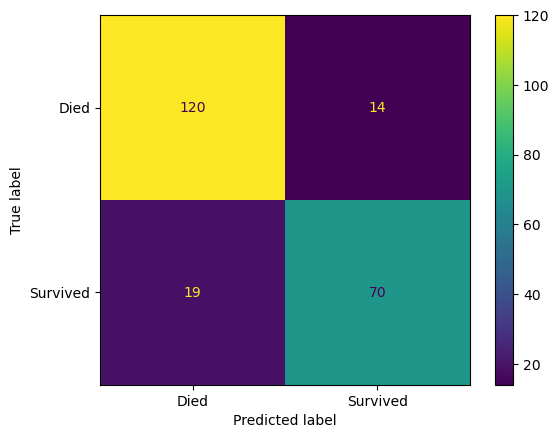

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming clf is your trained model
# Make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

ConfusionMatrixDisplay.from_estimator(grid_search,X_test,y_test,display_labels=['Died', 'Survived'])


In [10]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("f1 score:", f1)
print("accuracy score:", accuracy)
print("average precision score:", average_precision)
print("recall score:", recall)

f1 score: 0.8092485549132948
accuracy score: 0.852017937219731
average precision score: 0.7406325053324601
recall score: 0.7865168539325843


Wyniki zbliżone jak w przypadku pojedynczych drzew. Accuracy score wzrósł o 2pp.

## 7.2
Test the classification accuracy achieved with the classifier
RandomForest on a set of Breast Cancer (results of tenfold cross-validation). What values of model parameters give the best results?Does the use of PCA significantly affect the results achieved?

In [11]:
df_cancer = load_breast_cancer()
X = df_cancer.data
y = df_cancer.target

In [12]:
class TestRandomForest():
    def __init__(self, X, y):
        self.parameters = {
            "pca__n_components": np.arange(1, 10),
            "rf__max_depth": np.arange(1, 10),
            'rf__min_samples_leaf': np.arange(1, 10)
        }
        self.X = X
        self.y = y
        
    def test_plot_rf(self):
        pca = PCA()
        rf = RandomForestClassifier()
        pipe = Pipeline(steps=[("pca", pca), ("rf", rf)])
 
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.25, random_state=42)
        
        grid_search = GridSearchCV(pipe, self.parameters, cv=10)
        grid_search.fit(X_train, y_train)
        
        print("Best Params:", grid_search.best_params_)
        print("Best Score:", grid_search.best_score_)
        
        # Test the model on the test set
        y_pred = grid_search.predict(X_test)

        test_accuracy = accuracy_score(y_test, y_pred)
        print("Test Accuracy:", test_accuracy)

        # Plotting the results
        cv_results = grid_search.cv_results_
        mean_test_score = cv_results['mean_test_score']
        std_test_score = cv_results['std_test_score']
        params = cv_results['params']

        # Extracting the number of components for PCA
        pca_n_components = [param['pca__n_components'] for param in params]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.errorbar(pca_n_components, mean_test_score, yerr=std_test_score, fmt='-o')
        plt.title('Grid Search Results')
        plt.xlabel('PCA Components')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()

        

In [13]:
rf = TestRandomForest(X,y)

Best Params: {'pca__n_components': 5, 'rf__max_depth': 7, 'rf__min_samples_leaf': 2}
Best Score: 0.9552048726467331
Test Accuracy: 0.965034965034965


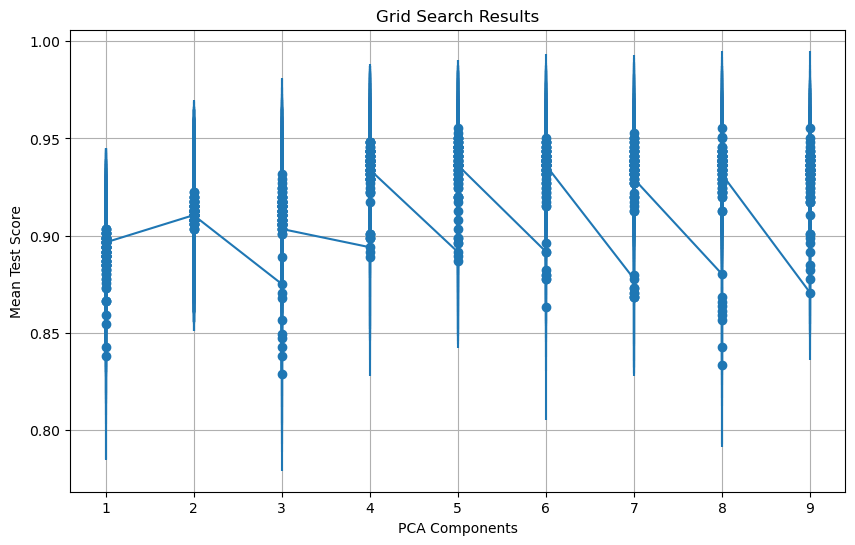

In [14]:
rf.test_plot_rf()

Najlepsze wyniki osiągamy przy korzystaniu z 5 składowych PCA, głębokości 7 i rf_min_samples_leaf 2

Wraz ze wzrostem PCA do wartości 5 wzrasta nam mean_test_score, natomiast dla większej ilości pca, spada